In [2]:
import os
from tqdm import tqdm
import glob
from astropy.io import fits
import os
from astropy.io import fits
from astropy.wcs import WCS
from spherical_geometry.polygon import SphericalPolygon
import os
from astropy.io import fits
from astropy.wcs import WCS
from spherical_geometry.polygon import SphericalPolygon
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def get_all_fits_files(root_dir):
    # Use glob to recursively find all .fits files
    pattern = os.path.join(root_dir, '**', '*.fits')
    fits_files = glob.glob(pattern, recursive=True)
    return fits_files

all_fits_paths = get_all_fits_files('.')
len(all_fits_paths)

7537

In [3]:
valid_fits_paths = []

for p in tqdm(all_fits_paths):
    with fits.open(path1) as hdul:
        if hdul[0].header['FILTER'] == 'F200W':
            valid_fits_paths.append(p)
        else:
            print(hdul[0].header['FILTER'])
            
len(valid_fits_paths)

  0%|                                                  | 0/7537 [00:00<?, ?it/s]


NameError: name 'path1' is not defined

In [ ]:
from collections import defaultdict

def build_file_dict(file_list):
    """
    Build a dictionary mapping base file paths to lists of suffixes.

    Parameters:
    file_list (list of str): List of file paths.

    Returns:
    dict: Dictionary where keys are base file paths and values are lists of suffixes.
    """
    file_dict = defaultdict(list)

    for filepath in tqdm(file_list):
        # Split the filepath to get the base and suffix
        base, suffix = filepath.rsplit('_', 2)[0], '_' + '_'.join(filepath.rsplit('_', 2)[1:])
        file_dict[base].append(suffix)

    return dict(file_dict)

file_dict = build_file_dict(valid_fits_paths)

In [ ]:
# Initialize the list of confirmed FITS paths
confirmed_fits_paths1 = []

all_polys1 = []

ct = 0

for prefix, suffixes in tqdm(file_dict.items()):
    total_poly = None
    for suffix in suffixes:
        path1 = prefix + suffix
        try:
            with fits.open(path1) as hdul:
                print(hdul.info())
                break
                hdul[1].data = hdul[1].data[0, 0]
                wcs1a = WCS(hdul[1].header)
                shape1a = sorted(tuple(wcs1a.pixel_shape))[:2]
                footprint1a = wcs1a.calc_footprint(axes=shape1a)
                
                plot_rectangle(footprint1a)
                
                poly1a = SphericalPolygon.from_radec(footprint1a[:, 0], footprint1a[:, 1])
                
                if total_poly is None:
                    total_poly = poly1a
                else:
                    total_poly = total_poly.union(poly1a)
        except Exception as e:
            print(e)
            continue

    all_polys.append(total_poly)
    confirmed_fits_paths.append(prefix)
    
    ct += 1
    if ct > 1:
        plt.show()

In [35]:
latitudes = []
longitudes = []

for poly in tqdm(all_polys):
    pts = list(poly.to_radec())[0]
    ra = pts[0][0]
    dec = pts[1][0]
    
    longitudes.append(ra)
    latitudes.append(dec)

100%|█████████████████████████████████████| 1157/1157 [00:00<00:00, 9673.87it/s]


In [36]:
n_points = len(latitudes)

# Repeat each point n_points times for lat1, lon1
lat1 = np.repeat(latitudes, n_points)
lon1 = np.repeat(longitudes, n_points)

# Tile the whole array n_points times for lat2, lon2
lat2 = np.tile(latitudes, n_points)
lon2 = np.tile(longitudes, n_points)

# Calculates angular separation between two spherical coords
# This can be lat/lon or ra/dec
# Taken from astropy
def angular_separation_deg(lon1, lat1, lon2, lat2):
    lon1 = np.deg2rad(lon1)
    lon2 = np.deg2rad(lon2)
    lat1 = np.deg2rad(lat1)
    lat2 = np.deg2rad(lat2)
    
    sdlon = np.sin(lon2 - lon1)
    cdlon = np.cos(lon2 - lon1)
    slat1 = np.sin(lat1)
    slat2 = np.sin(lat2)
    clat1 = np.cos(lat1)
    clat2 = np.cos(lat2)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.rad2deg(np.arctan2(np.hypot(num1, num2), denominator))

# Compute the pairwise angular separations
angular_separations = angular_separation_deg(lon1, lat1, lon2, lat2)

# Reshape the result into a matrix form
angular_separations_matrix = angular_separations.reshape(n_points, n_points)

def check_symmetric(a, rtol=1e-05, atol=1e-07):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

print("Symmetric?")
print(check_symmetric(angular_separations_matrix))
print(angular_separations_matrix.shape)

Symmetric?
True
(1157, 1157)


In [37]:
#JWST_FOV = 0.1
# This is 6 arcmin; both detectors are 5.1 by 2.2 arcmin
JWST_FOV = 0.085 # 5.1 arcmin

# Initial clustering from RA DEC only

THRESH = JWST_FOV * 2

clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='single', distance_threshold=THRESH)
labels = clustering.fit_predict(angular_separations_matrix)

In [38]:
pd.Series(labels).value_counts()

19     89
38     49
120    41
145    40
70     40
       ..
106     1
133     1
113     1
142     1
127     1
Name: count, Length: 158, dtype: int64

In [82]:
failed_labels = []
failed_paths = []

# Compute spherical polygon overlaps to verify overlap and remove ones that overlap

for label in tqdm(np.unique(labels)):
    polys = [(all_polys[i], confirmed_fits_paths[i]) for i in range(len(labels)) if labels[i] == label]
    if len(polys) > 1:
        total_poly = polys[0][0]
        for i in range(1, len(polys)):
            new_poly = polys[i][0]
            new_path = polys[i][1]
            if total_poly.intersects_poly(new_poly):
                union_over_max = total_poly.intersection(new_poly).area() / new_poly.area()
                print(f"FAIL label: {label}, i: {i} IoU: {union_over_max}")
                failed_labels.append(label)
                failed_paths.append(new_path)
                continue
            else:
                total_poly = total_poly.union(new_poly)

  1%|▎                                          | 1/158 [00:00<02:10,  1.20it/s]

FAIL label: 1, i: 3 IoU: 0.596504425087758


  1%|▌                                          | 2/158 [00:10<15:39,  6.02s/it]

FAIL label: 2, i: 2 IoU: 0.34363724115294875
FAIL label: 2, i: 3 IoU: 0.9976215196100199
FAIL label: 2, i: 4 IoU: 0.049803398542476354
FAIL label: 2, i: 5 IoU: 0.34417848130128015
FAIL label: 2, i: 6 IoU: 0.050723662560985434
FAIL label: 2, i: 7 IoU: 0.9690881457893782
FAIL label: 2, i: 8 IoU: 0.016727240411126703


  2%|▊                                          | 3/158 [00:13<12:23,  4.79s/it]

FAIL label: 2, i: 9 IoU: 0.051363243220488235
FAIL label: 3, i: 2 IoU: 0.8772338341742306
FAIL label: 3, i: 3 IoU: 0.6033748465129958
FAIL label: 3, i: 4 IoU: 0.772891871262731
FAIL label: 3, i: 5 IoU: 0.6831373397854319
FAIL label: 3, i: 6 IoU: 0.5340221026195638
FAIL label: 3, i: 7 IoU: 0.772905655459724
FAIL label: 3, i: 8 IoU: 0.772890592692672


  3%|█                                          | 4/158 [00:20<13:54,  5.42s/it]

FAIL label: 3, i: 9 IoU: 0.8772302526430777
FAIL label: 4, i: 1 IoU: 0.909832585344332
FAIL label: 4, i: 4 IoU: 0.8025004233260927
FAIL label: 4, i: 5 IoU: 0.8453293017068085
FAIL label: 4, i: 6 IoU: 0.9765939688413316
FAIL label: 4, i: 7 IoU: 0.9882627477713982
FAIL label: 4, i: 8 IoU: 0.7624884879588034
FAIL label: 4, i: 9 IoU: 0.8025139110760734


  3%|█▎                                         | 5/158 [00:29<17:31,  6.88s/it]

FAIL label: 4, i: 10 IoU: 0.8025001441743084
FAIL label: 5, i: 2 IoU: 0.4496355511991237
FAIL label: 5, i: 3 IoU: 0.4588227417680728
FAIL label: 5, i: 4 IoU: 0.9957487200884658


  4%|█▋                                         | 6/158 [00:30<12:36,  4.98s/it]

FAIL label: 5, i: 5 IoU: 0.9950081446006347


  4%|█▉                                         | 7/158 [00:31<08:58,  3.56s/it]

FAIL label: 6, i: 1 IoU: 0.7122162230626211
FAIL label: 7, i: 1 IoU: 0.10093506292076006
FAIL label: 7, i: 2 IoU: 0.9998915615986623


  5%|██▏                                        | 8/158 [00:32<06:34,  2.63s/it]

FAIL label: 7, i: 3 IoU: 0.10939640800206532
FAIL label: 8, i: 2 IoU: 0.9912084265208747
FAIL label: 8, i: 3 IoU: 0.9865537737461816
FAIL label: 8, i: 4 IoU: 0.986622964141607
FAIL label: 8, i: 5 IoU: 0.9913135645293272
FAIL label: 8, i: 6 IoU: 0.9913186939395294


  6%|██▍                                        | 9/158 [00:39<09:49,  3.96s/it]

FAIL label: 8, i: 8 IoU: 0.9913006277472834
FAIL label: 9, i: 1 IoU: 0.7621271076354184
FAIL label: 9, i: 2 IoU: 0.8450710718376875


  6%|██▋                                       | 10/158 [00:41<08:13,  3.33s/it]

FAIL label: 9, i: 3 IoU: 0.8030564932324532
FAIL label: 9, i: 4 IoU: 0.999999990751099
FAIL label: 10, i: 1 IoU: 0.916000605364933


  7%|██▉                                       | 11/158 [00:41<06:21,  2.60s/it]

FAIL label: 10, i: 2 IoU: 0.9151461996335089
FAIL label: 11, i: 2 IoU: 0.9912637565838156
FAIL label: 11, i: 3 IoU: 0.9912612328123992


  8%|███▏                                      | 12/158 [00:44<06:16,  2.58s/it]

FAIL label: 11, i: 4 IoU: 0.9913025296454008
FAIL label: 12, i: 2 IoU: 0.6830654664457954
FAIL label: 12, i: 3 IoU: 0.8773594104753869
FAIL label: 12, i: 4 IoU: 0.6814276762267611
FAIL label: 12, i: 5 IoU: 0.9990068671379828
FAIL label: 12, i: 6 IoU: 0.6834578859973331
FAIL label: 12, i: 7 IoU: 0.7733918311827014
FAIL label: 12, i: 8 IoU: 0.8772340747780768
FAIL label: 12, i: 9 IoU: 0.772902072485895
FAIL label: 12, i: 10 IoU: 0.683083780992213
FAIL label: 12, i: 11 IoU: 0.603786226689533
FAIL label: 12, i: 12 IoU: 0.7734041418188575


  8%|███▍                                      | 13/158 [00:53<10:33,  4.37s/it]

FAIL label: 12, i: 13 IoU: 0.9990233600686207


  9%|███▋                                      | 14/158 [00:53<07:29,  3.12s/it]

FAIL label: 13, i: 1 IoU: 0.47216301251728043
FAIL label: 14, i: 1 IoU: 0.9169049880588698
FAIL label: 14, i: 2 IoU: 0.843307430477678
FAIL label: 14, i: 3 IoU: 0.8672320389669367


  9%|███▉                                      | 15/158 [00:55<06:45,  2.83s/it]

FAIL label: 14, i: 4 IoU: 0.8013347757661077
FAIL label: 15, i: 1 IoU: 0.9954379957198788
FAIL label: 15, i: 2 IoU: 0.9939489890173334
FAIL label: 15, i: 3 IoU: 0.9954511582506983


 10%|████▎                                     | 16/158 [00:56<05:39,  2.39s/it]

FAIL label: 15, i: 4 IoU: 0.9894314896039336
FAIL label: 16, i: 1 IoU: 0.9153973737877844
FAIL label: 16, i: 2 IoU: 0.8433466312045649
FAIL label: 16, i: 3 IoU: 0.7987078131370232


 11%|████▌                                     | 17/158 [00:58<05:28,  2.33s/it]

FAIL label: 16, i: 4 IoU: 0.8654809533467365
FAIL label: 17, i: 1 IoU: 0.8433790371270119


 11%|████▊                                     | 18/158 [01:00<04:34,  1.96s/it]

FAIL label: 17, i: 2 IoU: 0.9160603832849191
FAIL label: 18, i: 3 IoU: 0.9882684639969264
FAIL label: 18, i: 4 IoU: 0.0025188064621530465
FAIL label: 18, i: 5 IoU: 0.0484668306380221
FAIL label: 18, i: 6 IoU: 0.5848858905090375
FAIL label: 18, i: 7 IoU: 0.01365337421431782
FAIL label: 18, i: 8 IoU: 0.012351783016065904
FAIL label: 18, i: 9 IoU: 0.2416277252965741
FAIL label: 18, i: 10 IoU: 0.5837599658422793
FAIL label: 18, i: 11 IoU: 0.0032292368173571957
FAIL label: 18, i: 12 IoU: 0.045870357014619584
FAIL label: 18, i: 13 IoU: 0.025027863919334377
FAIL label: 18, i: 14 IoU: 0.04715498646147894
FAIL label: 18, i: 15 IoU: 0.014989417119491494
FAIL label: 18, i: 16 IoU: 0.9765959736164441
FAIL label: 18, i: 17 IoU: 0.5857512473047392
FAIL label: 18, i: 18 IoU: 0.24273894598992174
FAIL label: 18, i: 19 IoU: 0.02005236853676387
FAIL label: 18, i: 20 IoU: 0.027250288584163125
FAIL label: 18, i: 21 IoU: 0.025488794945425854
FAIL label: 18, i: 22 IoU: 0.025289672205581298
FAIL label: 18, i:

 12%|█████                                     | 19/158 [01:20<17:14,  7.44s/it]

FAIL label: 18, i: 32 IoU: 0.9557206186978192
FAIL label: 19, i: 2 IoU: 0.9774512422414808
FAIL label: 19, i: 3 IoU: 0.03800596678121059
FAIL label: 19, i: 6 IoU: 0.7829255632049799
FAIL label: 19, i: 8 IoU: 0.9746636707728144
FAIL label: 19, i: 9 IoU: 0.19587164001707222
FAIL label: 19, i: 10 IoU: 0.30380911467953886
FAIL label: 19, i: 11 IoU: 0.18641665627856108
FAIL label: 19, i: 12 IoU: 0.08236341553678125
FAIL label: 19, i: 13 IoU: 0.015784931793429914
FAIL label: 19, i: 14 IoU: 0.024861524805580473
FAIL label: 19, i: 15 IoU: 0.5423330644834442
FAIL label: 19, i: 16 IoU: 0.035131974942288896
FAIL label: 19, i: 18 IoU: 0.1809097032842005
FAIL label: 19, i: 19 IoU: 0.19562169352965575
FAIL label: 19, i: 20 IoU: 0.9826473212266222
FAIL label: 19, i: 21 IoU: 0.19587126373686517
FAIL label: 19, i: 22 IoU: 0.9883075670752045
FAIL label: 19, i: 23 IoU: 0.18152681652772515
FAIL label: 19, i: 24 IoU: 0.24652929358453682
FAIL label: 19, i: 25 IoU: 0.04213105148731472
FAIL label: 19, i: 27 I

 13%|█████                                   | 20/158 [03:19<1:34:12, 40.96s/it]

FAIL label: 19, i: 88 IoU: 0.790623023166806
FAIL label: 20, i: 1 IoU: 0.8434105415636716
FAIL label: 20, i: 2 IoU: 0.9161239966430783


 13%|█████▎                                  | 21/158 [03:20<1:06:31, 29.14s/it]

FAIL label: 20, i: 3 IoU: 0.9151125025499951
FAIL label: 21, i: 1 IoU: 0.682936365942041
FAIL label: 21, i: 3 IoU: 0.7461944940821114
FAIL label: 21, i: 4 IoU: 0.942697559584912
FAIL label: 21, i: 5 IoU: 0.773066337158479
FAIL label: 21, i: 6 IoU: 0.580660187921634
FAIL label: 21, i: 7 IoU: 0.7730732256044107
FAIL label: 21, i: 8 IoU: 0.5753414881623378
FAIL label: 21, i: 9 IoU: 0.9367130313753453


 14%|█████▊                                    | 22/158 [03:28<51:19, 22.64s/it]

FAIL label: 21, i: 10 IoU: 0.9209076100173705
FAIL label: 22, i: 1 IoU: 0.007972203927431606
FAIL label: 22, i: 2 IoU: 0.059654487893238524
FAIL label: 22, i: 3 IoU: 0.8292869581756113
FAIL label: 22, i: 4 IoU: 0.07132877161933554
FAIL label: 22, i: 5 IoU: 0.007594431801768884
FAIL label: 22, i: 7 IoU: 0.861914023770954
FAIL label: 22, i: 9 IoU: 0.8450643035298813
FAIL label: 22, i: 10 IoU: 0.9886794814448442
FAIL label: 22, i: 11 IoU: 0.007121621681412606
FAIL label: 22, i: 12 IoU: 0.20833300850716094
FAIL label: 22, i: 14 IoU: 0.003099958623662712
FAIL label: 22, i: 15 IoU: 0.20164529473915005
FAIL label: 22, i: 16 IoU: 0.9941267137858101
FAIL label: 22, i: 17 IoU: 0.8450583587990915
FAIL label: 22, i: 18 IoU: 0.9766066111713275
FAIL label: 22, i: 19 IoU: 0.86191648401938
FAIL label: 22, i: 20 IoU: 0.004995260150536424
FAIL label: 22, i: 21 IoU: 0.1103390137021025
FAIL label: 22, i: 22 IoU: 0.43086341739676437
FAIL label: 22, i: 23 IoU: 0.9657493686209166
FAIL label: 22, i: 24 IoU: 0

 15%|██████                                    | 23/158 [04:02<58:20, 25.93s/it]

FAIL label: 22, i: 30 IoU: 0.5257882060627843
FAIL label: 23, i: 1 IoU: 0.2443012277230269
FAIL label: 23, i: 2 IoU: 0.2629469166206281
FAIL label: 23, i: 3 IoU: 0.603125439731787
FAIL label: 23, i: 4 IoU: 0.002134816632811821
FAIL label: 23, i: 6 IoU: 0.762074868367664
FAIL label: 23, i: 7 IoU: 0.2662032622949123
FAIL label: 23, i: 8 IoU: 0.25060850712024413
FAIL label: 23, i: 9 IoU: 0.08065164804724086
FAIL label: 23, i: 10 IoU: 0.6834130250533637
FAIL label: 23, i: 11 IoU: 0.2661181797936193
FAIL label: 23, i: 12 IoU: 0.1160018663088608
FAIL label: 23, i: 13 IoU: 0.1164853470314532
FAIL label: 23, i: 14 IoU: 0.08187484726229202
FAIL label: 23, i: 15 IoU: 0.07999823123893308
FAIL label: 23, i: 16 IoU: 0.0693676865767367
FAIL label: 23, i: 17 IoU: 0.9886264186659558
FAIL label: 23, i: 18 IoU: 0.999664275566909
FAIL label: 23, i: 19 IoU: 0.08187528162852865
FAIL label: 23, i: 20 IoU: 0.8023770954029319
FAIL label: 23, i: 21 IoU: 0.845033052236314
FAIL label: 23, i: 22 IoU: 0.6092412831

 15%|██████▍                                   | 24/158 [04:15<49:34, 22.20s/it]

FAIL label: 23, i: 27 IoU: 0.03912375663760288
FAIL label: 24, i: 1 IoU: 0.9151912871209427
FAIL label: 24, i: 2 IoU: 0.4001382279773053
FAIL label: 24, i: 3 IoU: 0.40209338947818773


 16%|██████▋                                   | 25/158 [04:17<35:36, 16.06s/it]

FAIL label: 24, i: 4 IoU: 0.9160006872466848


 16%|██████▉                                   | 26/158 [04:17<25:10, 11.44s/it]

FAIL label: 25, i: 1 IoU: 0.8435441191311661
FAIL label: 26, i: 2 IoU: 0.44452034396996065


 18%|███████▍                                  | 28/158 [04:20<13:28,  6.22s/it]

FAIL label: 27, i: 1 IoU: 0.3780093395774429
FAIL label: 28, i: 1 IoU: 0.8435572448767735
FAIL label: 28, i: 2 IoU: 0.9158190013237093


 18%|███████▋                                  | 29/158 [04:22<10:21,  4.82s/it]

FAIL label: 28, i: 3 IoU: 0.9153602519939127
FAIL label: 29, i: 1 IoU: 0.31016376706269033
FAIL label: 30, i: 1 IoU: 0.20075819425965785
FAIL label: 30, i: 2 IoU: 0.23397765083248212
FAIL label: 30, i: 3 IoU: 0.36580790532882856
FAIL label: 30, i: 4 IoU: 0.1763778717696363
FAIL label: 30, i: 5 IoU: 0.4856774646168649


 20%|████████▏                                 | 31/158 [04:24<06:28,  3.06s/it]

FAIL label: 30, i: 6 IoU: 0.7745676323720219
FAIL label: 31, i: 1 IoU: 0.8433428092058702
FAIL label: 31, i: 3 IoU: 0.9999854732709319
FAIL label: 31, i: 4 IoU: 0.8433537580990518
FAIL label: 31, i: 5 IoU: 0.9153839553419709
FAIL label: 31, i: 6 IoU: 0.33960886624849795
FAIL label: 31, i: 7 IoU: 0.915849959665912
FAIL label: 31, i: 8 IoU: 0.8433616437543685


 20%|████████▌                                 | 32/158 [04:30<07:59,  3.81s/it]

FAIL label: 31, i: 9 IoU: 0.9153867620271284
FAIL label: 32, i: 3 IoU: 0.5194314897298614
FAIL label: 32, i: 5 IoU: 0.48701543222226085
FAIL label: 32, i: 6 IoU: 0.06253425454904543
FAIL label: 32, i: 8 IoU: 0.066993864512601
FAIL label: 32, i: 9 IoU: 0.47937376371056784
FAIL label: 32, i: 10 IoU: 0.9657884975091581
FAIL label: 32, i: 13 IoU: 0.5373060874256407
FAIL label: 32, i: 14 IoU: 0.07975110199098062
FAIL label: 32, i: 15 IoU: 0.521148230072425
FAIL label: 32, i: 16 IoU: 0.05295243365244401
FAIL label: 32, i: 17 IoU: 0.5183182222406223
FAIL label: 32, i: 18 IoU: 0.9694721415100868
FAIL label: 32, i: 19 IoU: 0.8855027323419071
FAIL label: 32, i: 20 IoU: 0.519910193182164
FAIL label: 32, i: 21 IoU: 0.1095659456606161
FAIL label: 32, i: 22 IoU: 0.9657965177785731
FAIL label: 32, i: 23 IoU: 0.2605878483426083
FAIL label: 32, i: 24 IoU: 0.08763282323348302
FAIL label: 32, i: 25 IoU: 0.9658142661354232
FAIL label: 32, i: 26 IoU: 0.9657912749701886
FAIL label: 32, i: 27 IoU: 0.49008342

 21%|████████▊                                 | 33/158 [05:59<54:11, 26.01s/it]

FAIL label: 32, i: 35 IoU: 0.36685879823460277
FAIL label: 33, i: 1 IoU: 0.3850491250619594
FAIL label: 33, i: 2 IoU: 0.3898977762133232
FAIL label: 33, i: 3 IoU: 0.5955706225230821
FAIL label: 33, i: 5 IoU: 0.3892251847518628
FAIL label: 33, i: 6 IoU: 0.8245936777323138
FAIL label: 33, i: 7 IoU: 0.8033995566585375


 22%|█████████                                 | 34/158 [06:04<42:08, 20.39s/it]

FAIL label: 33, i: 8 IoU: 0.8028234766394551


 22%|█████████▎                                | 35/158 [06:04<30:23, 14.82s/it]

FAIL label: 34, i: 1 IoU: 0.8430133082011527
FAIL label: 34, i: 2 IoU: 0.9136781914465233
FAIL label: 35, i: 1 IoU: 0.4341019720196542
FAIL label: 35, i: 2 IoU: 0.4193767602363829
FAIL label: 35, i: 3 IoU: 0.7751335307059177
FAIL label: 35, i: 4 IoU: 0.4684109741530189


 23%|█████████▌                                | 36/158 [06:06<22:38, 11.13s/it]

FAIL label: 35, i: 5 IoU: 0.7930069734869111
FAIL label: 36, i: 1 IoU: 0.8026237012147692
FAIL label: 36, i: 2 IoU: 0.8030950746947939
FAIL label: 36, i: 3 IoU: 0.825649414518111


 23%|█████████▊                                | 37/158 [06:08<17:07,  8.49s/it]

FAIL label: 36, i: 4 IoU: 0.9999938185126345
FAIL label: 37, i: 1 IoU: 0.46705828758092655
FAIL label: 37, i: 2 IoU: 0.6004481697553506
FAIL label: 37, i: 3 IoU: 0.9938366982602898
FAIL label: 37, i: 4 IoU: 0.46560517038867194


 24%|██████████                                | 38/158 [06:11<13:42,  6.85s/it]

FAIL label: 37, i: 5 IoU: 0.6012176933923705
FAIL label: 38, i: 2 IoU: 0.512634809409788
FAIL label: 38, i: 3 IoU: 0.14561119443695505
FAIL label: 38, i: 4 IoU: 0.08635479828626166
FAIL label: 38, i: 6 IoU: 0.018696336312759188
FAIL label: 38, i: 7 IoU: 0.40038567968865635
FAIL label: 38, i: 8 IoU: 0.13205832847235766
FAIL label: 38, i: 10 IoU: 0.35086477055465815
FAIL label: 38, i: 11 IoU: 0.35354185027722945
FAIL label: 38, i: 12 IoU: 0.9656759647879102
FAIL label: 38, i: 13 IoU: 0.6683543369793867
FAIL label: 38, i: 14 IoU: 0.132343396267148
FAIL label: 38, i: 15 IoU: 0.06523118557512708
FAIL label: 38, i: 16 IoU: 0.588532582979945
FAIL label: 38, i: 17 IoU: 0.5752334732748579
FAIL label: 38, i: 18 IoU: 0.6286812854836555
FAIL label: 38, i: 19 IoU: 0.08728396674871344
FAIL label: 38, i: 20 IoU: 0.14558953986946302
FAIL label: 38, i: 21 IoU: 0.30012835610663957
FAIL label: 38, i: 22 IoU: 0.39793028068973313
FAIL label: 38, i: 23 IoU: 0.13034107831693614
FAIL label: 38, i: 24 IoU: 0.2

 25%|██████████▎                               | 39/158 [06:49<31:36, 15.94s/it]

FAIL label: 38, i: 48 IoU: 0.6735502456632044
FAIL label: 39, i: 1 IoU: 0.03395818425107658
FAIL label: 39, i: 3 IoU: 0.9938338904061738
FAIL label: 39, i: 4 IoU: 0.5558974851150621
FAIL label: 39, i: 5 IoU: 0.13515297477445243
FAIL label: 39, i: 6 IoU: 0.9938401186377048
FAIL label: 39, i: 7 IoU: 0.5558970571431593
FAIL label: 39, i: 8 IoU: 0.5542847032177561
FAIL label: 39, i: 9 IoU: 0.135076335623055
FAIL label: 39, i: 10 IoU: 0.5542799555295289


 25%|██████████▋                               | 40/158 [06:56<26:13, 13.33s/it]

FAIL label: 39, i: 11 IoU: 0.135550007444671
FAIL label: 40, i: 1 IoU: 0.9151075686460775


 26%|██████████▉                               | 41/158 [06:57<18:53,  9.69s/it]

FAIL label: 40, i: 2 IoU: 0.8436006772408544
FAIL label: 41, i: 1 IoU: 0.08982039972622885
FAIL label: 41, i: 3 IoU: 0.0900551149498885
FAIL label: 41, i: 4 IoU: 0.5601937507713781
FAIL label: 41, i: 5 IoU: 0.5934232946804547
FAIL label: 41, i: 6 IoU: 0.9095844999195681
FAIL label: 41, i: 7 IoU: 0.09971748826044609
FAIL label: 41, i: 8 IoU: 0.9628509630330621
FAIL label: 41, i: 9 IoU: 0.08910474208383451
FAIL label: 41, i: 10 IoU: 0.061510665401247944
FAIL label: 41, i: 11 IoU: 0.5981617378845803
FAIL label: 41, i: 12 IoU: 0.09851176647403143
FAIL label: 41, i: 13 IoU: 0.1461561727270611
FAIL label: 41, i: 14 IoU: 0.5498825904916589
FAIL label: 41, i: 15 IoU: 0.9690820588881474
FAIL label: 41, i: 16 IoU: 0.1447957767564122
FAIL label: 41, i: 17 IoU: 0.5550135072278303


 27%|███████████▏                              | 42/158 [07:07<18:37,  9.64s/it]

FAIL label: 41, i: 18 IoU: 0.09996566539149877


 27%|███████████▍                              | 43/158 [07:07<13:04,  6.82s/it]

FAIL label: 42, i: 1 IoU: 0.007356975249176217
FAIL label: 43, i: 1 IoU: 0.09066304958321912
FAIL label: 43, i: 2 IoU: 0.10004553025464684
FAIL label: 43, i: 3 IoU: 0.1979231541062441
FAIL label: 43, i: 4 IoU: 0.18354782782767767
FAIL label: 43, i: 5 IoU: 0.19149790024589028
FAIL label: 43, i: 6 IoU: 0.0963780439900404


 28%|███████████▋                              | 44/158 [07:08<09:54,  5.22s/it]

FAIL label: 43, i: 7 IoU: 0.9469711995110248
FAIL label: 44, i: 1 IoU: 0.15358004784777474
FAIL label: 44, i: 2 IoU: 0.8271163487989152
FAIL label: 44, i: 3 IoU: 0.2624353114013321


 28%|███████████▉                              | 45/158 [07:09<07:34,  4.02s/it]

FAIL label: 44, i: 4 IoU: 0.3661283097339448
FAIL label: 45, i: 1 IoU: 0.8239665784373518
FAIL label: 45, i: 2 IoU: 0.8258742967171462
FAIL label: 45, i: 3 IoU: 0.683772854655383
FAIL label: 45, i: 4 IoU: 0.8028207319094468
FAIL label: 45, i: 5 IoU: 0.8032681006904484


 29%|████████████▏                             | 46/158 [07:13<07:09,  3.84s/it]

FAIL label: 45, i: 6 IoU: 0.8026450020965097
FAIL label: 46, i: 1 IoU: 0.8427731719641065
FAIL label: 46, i: 2 IoU: 0.9153252573917504


 30%|████████████▍                             | 47/158 [07:14<05:26,  2.94s/it]

FAIL label: 46, i: 3 IoU: 0.9153096441817556
FAIL label: 46, i: 4 IoU: 0.9999925689445253
FAIL label: 47, i: 1 IoU: 0.9156245171130467


 30%|████████████▊                             | 48/158 [07:14<04:09,  2.27s/it]

FAIL label: 47, i: 2 IoU: 0.8428694894095335
FAIL label: 47, i: 3 IoU: 0.9155863298771904
FAIL label: 48, i: 1 IoU: 0.9990096446001775
FAIL label: 48, i: 2 IoU: 0.6830623133189799
FAIL label: 48, i: 3 IoU: 0.5350104012408574
FAIL label: 48, i: 4 IoU: 0.031982261459943
FAIL label: 48, i: 5 IoU: 0.04068509784273374
FAIL label: 48, i: 6 IoU: 0.13466017985187076
FAIL label: 48, i: 7 IoU: 0.04040415943774762


 31%|█████████████                             | 49/158 [07:18<04:48,  2.65s/it]

FAIL label: 48, i: 8 IoU: 0.5347324610899336
FAIL label: 49, i: 1 IoU: 0.7056960960939562
FAIL label: 49, i: 2 IoU: 0.2641066674154206
FAIL label: 49, i: 3 IoU: 0.7034484174264136
FAIL label: 49, i: 4 IoU: 0.223893987451369
FAIL label: 49, i: 5 IoU: 0.7097813131847331
FAIL label: 49, i: 6 IoU: 0.6999674950164896
FAIL label: 49, i: 7 IoU: 0.9683482114119665
FAIL label: 49, i: 8 IoU: 0.5964945603064827


 32%|█████████████▎                            | 50/158 [07:22<05:33,  3.09s/it]

FAIL label: 49, i: 9 IoU: 0.7042520673679805
FAIL label: 50, i: 1 IoU: 0.9152080388338767


 32%|█████████████▌                            | 51/158 [07:23<04:07,  2.31s/it]

FAIL label: 50, i: 2 IoU: 0.8429946283837287
FAIL label: 51, i: 1 IoU: 0.06500442154612261
FAIL label: 51, i: 2 IoU: 0.3583148252066979
FAIL label: 51, i: 3 IoU: 0.5991233570832903
FAIL label: 51, i: 4 IoU: 0.326756671506977


 33%|█████████████▊                            | 52/158 [07:25<04:02,  2.29s/it]

FAIL label: 51, i: 5 IoU: 0.7141559548200982


 34%|██████████████                            | 53/158 [07:25<02:57,  1.69s/it]

FAIL label: 52, i: 1 IoU: 0.8204446338202439
FAIL label: 53, i: 1 IoU: 0.9950753633270243
FAIL label: 53, i: 2 IoU: 0.9943879249206222
FAIL label: 53, i: 3 IoU: 0.9967325015603868


 34%|██████████████▎                           | 54/158 [07:26<02:44,  1.58s/it]

FAIL label: 53, i: 4 IoU: 0.9982532298844378
FAIL label: 54, i: 1 IoU: 0.9153262546386316


 35%|██████████████▌                           | 55/158 [07:27<02:15,  1.32s/it]

FAIL label: 54, i: 2 IoU: 0.8427723801425402
FAIL label: 54, i: 3 IoU: 0.9151308354337767


 35%|██████████████▉                           | 56/158 [07:27<01:43,  1.01s/it]

FAIL label: 55, i: 1 IoU: 0.7180463047952219
FAIL label: 56, i: 1 IoU: 0.5521606561357969
FAIL label: 56, i: 2 IoU: 0.8935054774845537
FAIL label: 56, i: 3 IoU: 0.8941069837868798
FAIL label: 56, i: 4 IoU: 0.6008961092266758
FAIL label: 56, i: 5 IoU: 0.5719062333183776
FAIL label: 56, i: 6 IoU: 0.5530414235191047
FAIL label: 56, i: 7 IoU: 0.8923087105751871
FAIL label: 56, i: 8 IoU: 0.5529215413504073


 36%|███████████████▏                          | 57/158 [07:33<03:54,  2.33s/it]

FAIL label: 56, i: 9 IoU: 0.8930717725268775
FAIL label: 56, i: 10 IoU: 0.9938836369672028
FAIL label: 57, i: 1 IoU: 0.996514617316769
FAIL label: 57, i: 2 IoU: 0.9952433732100152


 37%|███████████████▍                          | 58/158 [07:33<03:00,  1.80s/it]

FAIL label: 57, i: 3 IoU: 0.8212562267797656
FAIL label: 58, i: 1 IoU: 0.9999929200180288
FAIL label: 58, i: 2 IoU: 0.9149357087901604
FAIL label: 58, i: 3 IoU: 0.8429114380102499


 37%|███████████████▋                          | 59/158 [07:34<02:33,  1.55s/it]

FAIL label: 58, i: 4 IoU: 0.8429188483689624
FAIL label: 59, i: 1 IoU: 0.9169506782280462
FAIL label: 59, i: 2 IoU: 0.914190743487813


 38%|███████████████▉                          | 60/158 [07:36<02:30,  1.54s/it]

FAIL label: 59, i: 3 IoU: 0.8433107774078706
FAIL label: 60, i: 1 IoU: 0.8434393101603221
FAIL label: 60, i: 2 IoU: 0.916144540035421


 39%|████████████████▏                         | 61/158 [07:37<02:29,  1.54s/it]

FAIL label: 60, i: 3 IoU: 0.9149995049374438
FAIL label: 61, i: 1 IoU: 0.9155702465594511


 39%|████████████████▍                         | 62/158 [07:38<01:49,  1.14s/it]

FAIL label: 62, i: 1 IoU: 0.842973835838857
FAIL label: 62, i: 2 IoU: 0.8429872110037067


 40%|████████████████▋                         | 63/158 [07:39<01:46,  1.12s/it]

FAIL label: 62, i: 3 IoU: 0.8429822518730672
FAIL label: 62, i: 4 IoU: 0.915282352125502
FAIL label: 63, i: 1 IoU: 0.8429991739825993
FAIL label: 63, i: 2 IoU: 0.9169075551540835
FAIL label: 63, i: 3 IoU: 0.9135384482199937


 41%|█████████████████                         | 64/158 [07:40<01:42,  1.09s/it]

FAIL label: 63, i: 4 IoU: 0.9135352134605788
FAIL label: 64, i: 1 IoU: 0.5012803750471599
FAIL label: 64, i: 2 IoU: 0.7063042415272666


 41%|█████████████████▎                        | 65/158 [07:41<01:59,  1.28s/it]

FAIL label: 64, i: 3 IoU: 0.7002940401760164
FAIL label: 65, i: 1 IoU: 0.9155889112399954


 42%|█████████████████▌                        | 66/158 [07:42<01:36,  1.05s/it]

FAIL label: 65, i: 2 IoU: 0.8429077852408408
FAIL label: 66, i: 1 IoU: 0.9954569948880397
FAIL label: 66, i: 2 IoU: 0.3441210426307689
FAIL label: 66, i: 3 IoU: 0.993949136314007
FAIL label: 66, i: 4 IoU: 0.99392939015585
FAIL label: 66, i: 5 IoU: 0.9954392336272389
FAIL label: 66, i: 6 IoU: 0.3435827422112657
FAIL label: 66, i: 7 IoU: 0.3445256526435803


 43%|██████████████████                        | 68/158 [07:45<01:51,  1.24s/it]

FAIL label: 66, i: 8 IoU: 0.3454706812002677
FAIL label: 67, i: 1 IoU: 0.9614856798002672
FAIL label: 68, i: 1 IoU: 0.7002962733461816
FAIL label: 68, i: 2 IoU: 0.7000466537673152


 44%|██████████████████▎                       | 69/158 [07:47<02:08,  1.45s/it]

FAIL label: 68, i: 3 IoU: 0.7000536753226033
FAIL label: 69, i: 1 IoU: 0.715045875578728
FAIL label: 69, i: 2 IoU: 0.025139729172649943
FAIL label: 69, i: 3 IoU: 0.513694252322728
FAIL label: 69, i: 4 IoU: 0.7150512250960362
FAIL label: 69, i: 5 IoU: 0.3627834420305251
FAIL label: 69, i: 6 IoU: 0.030352599133712476
FAIL label: 69, i: 7 IoU: 0.11428311941702936
FAIL label: 69, i: 8 IoU: 0.05915608347442177
FAIL label: 69, i: 9 IoU: 0.10090682407856956
FAIL label: 69, i: 10 IoU: 0.7152687491217639
FAIL label: 69, i: 11 IoU: 0.36133406428096176
FAIL label: 69, i: 12 IoU: 0.7152628244739037
FAIL label: 69, i: 13 IoU: 0.5113774295936832
FAIL label: 69, i: 14 IoU: 0.11200529289620645
FAIL label: 69, i: 15 IoU: 0.04745674778348381
FAIL label: 69, i: 16 IoU: 0.05301934410664489
FAIL label: 69, i: 17 IoU: 0.04696729971101652
FAIL label: 69, i: 18 IoU: 0.0774657504366707


 44%|██████████████████▌                       | 70/158 [07:55<05:03,  3.45s/it]

FAIL label: 69, i: 19 IoU: 0.5055188273287422
FAIL label: 70, i: 1 IoU: 0.8532231099580838
FAIL label: 70, i: 2 IoU: 0.9173275535340609
FAIL label: 70, i: 3 IoU: 0.8212491506420617
FAIL label: 70, i: 4 IoU: 0.885239811569498
FAIL label: 70, i: 5 IoU: 0.7436426033143856
FAIL label: 70, i: 6 IoU: 0.7050439923513071
FAIL label: 70, i: 7 IoU: 0.8372292980016972
FAIL label: 70, i: 8 IoU: 0.6793367854872849
FAIL label: 70, i: 9 IoU: 0.8692239160602578
FAIL label: 70, i: 10 IoU: 0.9681905187615356
FAIL label: 70, i: 11 IoU: 0.32701484613707116
FAIL label: 70, i: 12 IoU: 0.3152310723328548
FAIL label: 70, i: 13 IoU: 0.3388230054889661
FAIL label: 70, i: 14 IoU: 0.44324667975293863
FAIL label: 70, i: 15 IoU: 0.4558390477857239
FAIL label: 70, i: 16 IoU: 0.32112039251888147
FAIL label: 70, i: 17 IoU: 0.40642740423461327
FAIL label: 70, i: 18 IoU: 0.3495958553200418
FAIL label: 70, i: 19 IoU: 0.4706882017483577
FAIL label: 70, i: 20 IoU: 0.4211677300975124
FAIL label: 70, i: 21 IoU: 0.35825052508

 46%|███████████████████▏                      | 72/158 [08:03<04:41,  3.27s/it]

FAIL label: 70, i: 39 IoU: 0.6664977652124676
FAIL label: 71, i: 1 IoU: 0.9821982969125563
FAIL label: 72, i: 1 IoU: 0.9152900520337373
FAIL label: 72, i: 2 IoU: 0.9158898492800907


 46%|███████████████████▍                      | 73/158 [08:04<03:55,  2.77s/it]

FAIL label: 72, i: 3 IoU: 0.8433729901286159
FAIL label: 73, i: 1 IoU: 1.0000000011689651
FAIL label: 73, i: 2 IoU: 0.999992723192376


 47%|███████████████████▋                      | 74/158 [08:05<03:07,  2.23s/it]

FAIL label: 73, i: 3 IoU: 0.9999980899110612
FAIL label: 73, i: 4 IoU: 0.9999997954311112


 47%|███████████████████▉                      | 75/158 [08:06<02:17,  1.65s/it]

FAIL label: 74, i: 1 IoU: 0.9799420062177642
FAIL label: 74, i: 2 IoU: 0.979874347241459


 48%|████████████████████▏                     | 76/158 [08:06<01:38,  1.20s/it]

FAIL label: 75, i: 1 IoU: 0.9556169247612657
FAIL label: 76, i: 1 IoU: 0.8428148299759883
FAIL label: 76, i: 2 IoU: 0.8428127917771737
FAIL label: 76, i: 3 IoU: 0.915065072149557


 49%|████████████████████▍                     | 77/158 [08:07<01:32,  1.14s/it]

FAIL label: 76, i: 4 IoU: 0.9154005764996468


 49%|████████████████████▋                     | 78/158 [08:07<01:15,  1.06it/s]

FAIL label: 77, i: 1 IoU: 0.9158167686218105
FAIL label: 78, i: 1 IoU: 0.9938279758250715


 50%|█████████████████████                     | 79/158 [08:08<01:05,  1.21it/s]

FAIL label: 78, i: 2 IoU: 0.9168879654282615
FAIL label: 78, i: 3 IoU: 0.9141136678929097
FAIL label: 80, i: 1 IoU: 0.811686115260117


 51%|█████████████████████▌                    | 81/158 [08:09<00:47,  1.61it/s]

FAIL label: 80, i: 2 IoU: 0.8116842335062312
FAIL label: 80, i: 3 IoU: 0.9999946847474193


 53%|██████████████████████                    | 83/158 [08:09<00:37,  1.98it/s]

FAIL label: 81, i: 1 IoU: 0.8119647042964662
FAIL label: 82, i: 1 IoU: 0.9954887478314629
FAIL label: 83, i: 1 IoU: 0.5875644719098534
FAIL label: 83, i: 2 IoU: 0.763486517479466
FAIL label: 83, i: 3 IoU: 0.5883098292426364


 53%|██████████████████████▎                   | 84/158 [08:11<00:59,  1.25it/s]

FAIL label: 83, i: 4 IoU: 0.6001201810830656
FAIL label: 84, i: 1 IoU: 0.9999895543935413
FAIL label: 84, i: 2 IoU: 0.9150862678249517
FAIL label: 84, i: 3 IoU: 0.9153853917971329


 54%|██████████████████████▌                   | 85/158 [08:12<01:00,  1.21it/s]

FAIL label: 84, i: 4 IoU: 0.8430140848763782
FAIL label: 85, i: 1 IoU: 0.9827706053045338
FAIL label: 85, i: 2 IoU: 0.315454848671191


 54%|██████████████████████▊                   | 86/158 [08:12<00:49,  1.47it/s]

FAIL label: 85, i: 3 IoU: 0.3163725085364393
FAIL label: 86, i: 1 IoU: 0.9151485340198658
FAIL label: 86, i: 2 IoU: 0.9999708491980615
FAIL label: 86, i: 3 IoU: 0.9151561291082108
FAIL label: 86, i: 4 IoU: 0.9151437104687598


 55%|███████████████████████▏                  | 87/158 [08:13<00:52,  1.36it/s]

FAIL label: 87, i: 1 IoU: 0.8213131353735267
FAIL label: 87, i: 2 IoU: 0.9965090024896376


 56%|███████████████████████▍                  | 88/158 [08:14<00:54,  1.27it/s]

FAIL label: 87, i: 3 IoU: 0.8207319285361833
FAIL label: 87, i: 4 IoU: 0.9943094943318893
FAIL label: 88, i: 2 IoU: 0.5334884719889734
FAIL label: 88, i: 3 IoU: 0.5342280152515528
FAIL label: 88, i: 4 IoU: 0.1640123309684527
FAIL label: 88, i: 5 IoU: 0.6461917152094128
FAIL label: 88, i: 6 IoU: 0.08677831082741233
FAIL label: 88, i: 7 IoU: 0.5049183533592696
FAIL label: 88, i: 8 IoU: 0.1595507733121335
FAIL label: 88, i: 9 IoU: 0.574309985514325
FAIL label: 88, i: 10 IoU: 0.29508346285602816
FAIL label: 88, i: 11 IoU: 0.08679589917744919
FAIL label: 88, i: 12 IoU: 0.10672382566136134
FAIL label: 88, i: 13 IoU: 0.8775570405305991
FAIL label: 88, i: 14 IoU: 0.8775913610590895
FAIL label: 88, i: 15 IoU: 0.5114310330853414
FAIL label: 88, i: 16 IoU: 0.602671706863789
FAIL label: 88, i: 17 IoU: 0.1964633894292634
FAIL label: 88, i: 18 IoU: 0.7153769595535522
FAIL label: 88, i: 19 IoU: 0.1197156122581966
FAIL label: 88, i: 20 IoU: 0.36209859166746006
FAIL label: 88, i: 21 IoU: 0.070584470593

 56%|███████████████████████▋                  | 89/158 [08:31<06:16,  5.46s/it]

FAIL label: 88, i: 29 IoU: 0.16446984033033477
FAIL label: 89, i: 1 IoU: 0.9162228080924544
FAIL label: 89, i: 2 IoU: 0.553103408414959
FAIL label: 89, i: 3 IoU: 0.5983941124765062
FAIL label: 89, i: 4 IoU: 0.9142743607290594


 57%|███████████████████████▉                  | 90/158 [08:33<05:16,  4.65s/it]

FAIL label: 89, i: 5 IoU: 0.59658258365518
FAIL label: 90, i: 1 IoU: 0.9999858774838961
FAIL label: 90, i: 2 IoU: 0.8429871602479023
FAIL label: 90, i: 3 IoU: 0.9153866184118814


 58%|████████████████████████▏                 | 91/158 [08:34<03:56,  3.52s/it]

FAIL label: 90, i: 4 IoU: 0.9150573463911605
FAIL label: 91, i: 1 IoU: 0.9954392429949537


 58%|████████████████████████▍                 | 92/158 [08:35<02:56,  2.67s/it]

FAIL label: 91, i: 2 IoU: 0.9954642109307051
FAIL label: 92, i: 1 IoU: 0.9154020207316252


 59%|████████████████████████▋                 | 93/158 [08:35<02:05,  1.94s/it]

FAIL label: 93, i: 1 IoU: 0.9954928165109435
FAIL label: 93, i: 2 IoU: 0.9954994565036105


 59%|████████████████████████▉                 | 94/158 [08:36<01:35,  1.49s/it]

FAIL label: 93, i: 3 IoU: 0.9957445042978423
FAIL label: 94, i: 1 IoU: 0.9957442608760956


 60%|█████████████████████████▎                | 95/158 [08:36<01:14,  1.18s/it]

FAIL label: 94, i: 2 IoU: 0.9954935303733637
FAIL label: 94, i: 3 IoU: 0.9955036342819167


 61%|█████████████████████████▌                | 96/158 [08:36<00:56,  1.09it/s]

FAIL label: 95, i: 1 IoU: 0.8212196187587691
FAIL label: 96, i: 1 IoU: 0.9997068819001476


 61%|█████████████████████████▊                | 97/158 [08:37<00:46,  1.31it/s]

FAIL label: 96, i: 2 IoU: 0.8234162276160522
FAIL label: 96, i: 3 IoU: 0.22801765149584644
FAIL label: 97, i: 1 IoU: 0.8338734984128814
FAIL label: 97, i: 2 IoU: 0.8427253634277804


 62%|██████████████████████████                | 98/158 [08:38<00:50,  1.19it/s]

FAIL label: 97, i: 3 IoU: 0.8547146936751142
FAIL label: 98, i: 1 IoU: 0.9942947515859598
FAIL label: 98, i: 2 IoU: 0.7180476943863174


 63%|██████████████████████████▎               | 99/158 [08:39<00:48,  1.23it/s]

FAIL label: 98, i: 3 IoU: 0.7165738698307893
FAIL label: 99, i: 1 IoU: 0.2683337049336944
FAIL label: 99, i: 2 IoU: 0.467150338282246
FAIL label: 99, i: 3 IoU: 0.485708991037263
FAIL label: 99, i: 4 IoU: 0.8272481402601363


 63%|█████████████████████████▉               | 100/158 [08:40<01:03,  1.09s/it]

FAIL label: 99, i: 5 IoU: 0.3662484602128929
FAIL label: 100, i: 1 IoU: 0.7178588760233511
FAIL label: 100, i: 2 IoU: 0.7163824134248742


 64%|██████████████████████████▏              | 101/158 [08:41<00:59,  1.05s/it]

FAIL label: 100, i: 3 IoU: 0.7169233738628326
FAIL label: 102, i: 1 IoU: 0.9999935519503039
FAIL label: 102, i: 2 IoU: 0.8429000214681437
FAIL label: 102, i: 3 IoU: 0.9130651869153273


 65%|██████████████████████████▋              | 103/158 [08:42<00:43,  1.27it/s]

FAIL label: 102, i: 4 IoU: 0.8428987619168794
FAIL label: 103, i: 1 IoU: 0.8447026797476835
FAIL label: 103, i: 2 IoU: 0.8447279116827182


 66%|██████████████████████████▉              | 104/158 [08:43<00:44,  1.22it/s]

FAIL label: 103, i: 3 IoU: 0.7617824427756772
FAIL label: 104, i: 1 IoU: 0.9965185727447226
FAIL label: 104, i: 2 IoU: 0.8213245503609953
FAIL label: 104, i: 3 IoU: 0.8223225750436894


 66%|███████████████████████████▏             | 105/158 [08:44<00:46,  1.14it/s]

FAIL label: 104, i: 4 IoU: 0.8203057178819239
FAIL label: 107, i: 1 IoU: 0.9656931879498398
FAIL label: 107, i: 2 IoU: 0.9272372792764422
FAIL label: 107, i: 3 IoU: 0.9366623502181541
FAIL label: 107, i: 4 IoU: 0.8089187218863569
FAIL label: 107, i: 5 IoU: 0.9089682384821981
FAIL label: 107, i: 6 IoU: 0.8738736228510605
FAIL label: 107, i: 7 IoU: 0.9611892193056012
FAIL label: 107, i: 8 IoU: 0.8089193659683054
FAIL label: 107, i: 9 IoU: 0.944071178173782
FAIL label: 107, i: 10 IoU: 0.9772744164149324
FAIL label: 107, i: 11 IoU: 0.9611917752114109
FAIL label: 107, i: 12 IoU: 0.8196907850055812
FAIL label: 107, i: 13 IoU: 0.8899433932386251
FAIL label: 107, i: 14 IoU: 0.936655899679712
FAIL label: 107, i: 15 IoU: 0.9656836573946403
FAIL label: 107, i: 16 IoU: 0.8569483106054716
FAIL label: 107, i: 17 IoU: 0.889939833353467
FAIL label: 107, i: 18 IoU: 0.9440732097190173
FAIL label: 107, i: 19 IoU: 0.9060931155718118
FAIL label: 107, i: 20 IoU: 0.9779341794555424
FAIL label: 107, i: 21 IoU

 68%|████████████████████████████             | 108/158 [08:51<01:22,  1.65s/it]

FAIL label: 107, i: 35 IoU: 0.9372476062499094


 69%|████████████████████████████▎            | 109/158 [08:52<01:08,  1.41s/it]

FAIL label: 108, i: 1 IoU: 0.8196080257046456
FAIL label: 108, i: 2 IoU: 0.9943122490751987
FAIL label: 109, i: 1 IoU: 0.9993161579901368
FAIL label: 109, i: 2 IoU: 0.9989257699586974


 70%|████████████████████████████▌            | 110/158 [08:52<01:01,  1.27s/it]

FAIL label: 109, i: 3 IoU: 0.8428535548403675
FAIL label: 109, i: 4 IoU: 0.9145080228723852
FAIL label: 110, i: 1 IoU: 0.8458423305585046
FAIL label: 110, i: 2 IoU: 0.8446410415391881
FAIL label: 110, i: 3 IoU: 0.8446363211184524


 70%|████████████████████████████▊            | 111/158 [08:54<00:58,  1.25s/it]

FAIL label: 110, i: 4 IoU: 0.8445268326246352
FAIL label: 111, i: 1 IoU: 0.9153160245554464


 71%|█████████████████████████████            | 112/158 [08:54<00:48,  1.06s/it]

FAIL label: 111, i: 2 IoU: 0.8430063452436769
FAIL label: 112, i: 1 IoU: 0.9976229388083134


 73%|█████████████████████████████▊           | 115/158 [08:55<00:22,  1.95it/s]

FAIL label: 112, i: 2 IoU: 0.9954903917550736
FAIL label: 114, i: 1 IoU: 0.9823037781119696
FAIL label: 115, i: 1 IoU: 0.8427372002386532
FAIL label: 115, i: 2 IoU: 0.9159599471588531


 73%|██████████████████████████████           | 116/158 [08:55<00:25,  1.65it/s]

FAIL label: 115, i: 3 IoU: 0.9145308202194943
FAIL label: 115, i: 4 IoU: 0.9159610237842082


 74%|██████████████████████████████▎          | 117/158 [08:56<00:23,  1.76it/s]

FAIL label: 116, i: 1 IoU: 0.9165528032329796
FAIL label: 118, i: 1 IoU: 0.9149094484933945


 75%|██████████████████████████████▉          | 119/158 [08:56<00:16,  2.32it/s]

FAIL label: 118, i: 2 IoU: 0.842885772933309
FAIL label: 119, i: 1 IoU: 0.5339275761090779
FAIL label: 119, i: 2 IoU: 0.010117243141230947
FAIL label: 119, i: 3 IoU: 0.8779858153241423
FAIL label: 119, i: 4 IoU: 0.008731847693585018
FAIL label: 119, i: 5 IoU: 0.6025841946309932
FAIL label: 119, i: 6 IoU: 0.7149578009042737
FAIL label: 119, i: 7 IoU: 0.05291368246003679
FAIL label: 119, i: 8 IoU: 0.01697632695848591


 76%|███████████████████████████████▏         | 120/158 [09:00<00:41,  1.09s/it]

FAIL label: 120, i: 1 IoU: 0.23368983292596965
FAIL label: 120, i: 2 IoU: 0.20409995307937817
FAIL label: 120, i: 3 IoU: 0.21704727446866512
FAIL label: 120, i: 4 IoU: 0.4117722652013406
FAIL label: 120, i: 5 IoU: 0.11634418210197194
FAIL label: 120, i: 6 IoU: 0.15453027600149247
FAIL label: 120, i: 7 IoU: 0.4218859979522584
FAIL label: 120, i: 8 IoU: 0.41101925187035865
FAIL label: 120, i: 10 IoU: 0.4488145529213503
FAIL label: 120, i: 11 IoU: 0.45516204616522016
FAIL label: 120, i: 12 IoU: 0.5449217581628534
FAIL label: 120, i: 13 IoU: 0.5631469104710431
FAIL label: 120, i: 14 IoU: 0.4948313653722433
FAIL label: 120, i: 15 IoU: 0.5546341441597754
FAIL label: 120, i: 16 IoU: 0.4376660447839837
FAIL label: 120, i: 17 IoU: 0.5805181813650909
FAIL label: 120, i: 18 IoU: 0.45464451838501874
FAIL label: 120, i: 19 IoU: 0.7391671138065253
FAIL label: 120, i: 20 IoU: 0.4680884778026279
FAIL label: 120, i: 21 IoU: 0.4443466671677894
FAIL label: 120, i: 22 IoU: 0.3887287470370856
FAIL label: 1

 78%|███████████████████████████████▉         | 123/158 [09:24<02:21,  4.04s/it]

FAIL label: 120, i: 40 IoU: 0.3901703825755954
FAIL label: 122, i: 1 IoU: 0.9822612186849033


 78%|████████████████████████████████▏        | 124/158 [09:24<01:47,  3.15s/it]

FAIL label: 123, i: 1 IoU: 0.9952728025301164
FAIL label: 124, i: 1 IoU: 0.9144128201401666
FAIL label: 124, i: 2 IoU: 0.9161508677454102


 79%|████████████████████████████████▍        | 125/158 [09:25<01:24,  2.55s/it]

FAIL label: 124, i: 3 IoU: 0.8430426673065566
FAIL label: 125, i: 1 IoU: 0.6927775379139705
FAIL label: 125, i: 2 IoU: 0.4937069668017305
FAIL label: 125, i: 3 IoU: 0.4958794352602853
FAIL label: 125, i: 4 IoU: 0.9208116264901149
FAIL label: 125, i: 5 IoU: 0.727631515760083
FAIL label: 125, i: 6 IoU: 0.505123108517373
FAIL label: 125, i: 7 IoU: 0.9218028225046004
FAIL label: 125, i: 8 IoU: 0.7237215574906564
FAIL label: 125, i: 9 IoU: 0.5073353705114093
FAIL label: 125, i: 10 IoU: 0.9938441721857603
FAIL label: 125, i: 11 IoU: 0.6959744100195436
FAIL label: 125, i: 12 IoU: 0.7028911414289177
FAIL label: 125, i: 13 IoU: 0.6519476658770348
FAIL label: 125, i: 14 IoU: 0.6518518727145441


 80%|████████████████████████████████▋        | 126/158 [09:28<01:28,  2.77s/it]

FAIL label: 125, i: 15 IoU: 0.7025855326538669
FAIL label: 126, i: 1 IoU: 0.049127163794319556
FAIL label: 126, i: 2 IoU: 0.915084072644163
FAIL label: 126, i: 3 IoU: 0.09556899782653447
FAIL label: 126, i: 4 IoU: 0.9150825509282297
FAIL label: 126, i: 5 IoU: 0.09556903248652653
FAIL label: 126, i: 6 IoU: 0.9153660527251942
FAIL label: 126, i: 7 IoU: 0.09557193703450216


 80%|████████████████████████████████▉        | 127/158 [09:30<01:13,  2.38s/it]

FAIL label: 126, i: 8 IoU: 0.9153799035463515
FAIL label: 126, i: 9 IoU: 0.08909456313183163


 82%|█████████████████████████████████▍       | 129/158 [09:30<00:39,  1.37s/it]

FAIL label: 128, i: 1 IoU: 0.982226359386617


 82%|█████████████████████████████████▋       | 130/158 [09:30<00:31,  1.12s/it]

FAIL label: 129, i: 1 IoU: 0.8114448341555182
FAIL label: 130, i: 1 IoU: 0.5180659140717497
FAIL label: 130, i: 2 IoU: 0.7207805818113393
FAIL label: 130, i: 3 IoU: 0.3237994130965319
FAIL label: 130, i: 4 IoU: 0.7205776887020672
FAIL label: 130, i: 5 IoU: 0.323989747876956


 83%|█████████████████████████████████▉       | 131/158 [09:34<00:48,  1.80s/it]

FAIL label: 130, i: 6 IoU: 0.5178014830024038
FAIL label: 131, i: 1 IoU: 0.915022796079141
FAIL label: 131, i: 2 IoU: 0.9154273382552026
FAIL label: 131, i: 3 IoU: 0.9150398022776599


 84%|██████████████████████████████████▎      | 132/158 [09:35<00:40,  1.56s/it]

FAIL label: 131, i: 4 IoU: 0.842803123213387
FAIL label: 132, i: 1 IoU: 0.9894330408329437
FAIL label: 132, i: 2 IoU: 0.4379817934133398
FAIL label: 132, i: 3 IoU: 0.9954541777034456
FAIL label: 132, i: 4 IoU: 0.43807245074647183


 84%|██████████████████████████████████▌      | 133/158 [09:37<00:42,  1.69s/it]

FAIL label: 132, i: 5 IoU: 0.9939513667205946


 85%|███████████████████████████████████      | 135/158 [09:37<00:23,  1.01s/it]

FAIL label: 134, i: 1 IoU: 0.8429304732147149
FAIL label: 135, i: 1 IoU: 0.8603302815672506
FAIL label: 135, i: 2 IoU: 0.8798327275495212
FAIL label: 135, i: 3 IoU: 0.7703044783114071
FAIL label: 135, i: 4 IoU: 0.6808827829759239
FAIL label: 135, i: 5 IoU: 0.6909746291700263
FAIL label: 135, i: 6 IoU: 0.5317420023883429


 86%|███████████████████████████████████▎     | 136/158 [09:41<00:38,  1.73s/it]

FAIL label: 135, i: 7 IoU: 0.5992982718981124
FAIL label: 136, i: 1 IoU: 0.36351635151746037
FAIL label: 136, i: 2 IoU: 0.7150202675633894
FAIL label: 136, i: 3 IoU: 0.07744958967554705
FAIL label: 136, i: 4 IoU: 0.11432450806194011
FAIL label: 136, i: 5 IoU: 0.05300909449687853
FAIL label: 136, i: 6 IoU: 0.03029251199066223
FAIL label: 136, i: 7 IoU: 0.3607440886125655
FAIL label: 136, i: 8 IoU: 0.10074075703871165
FAIL label: 136, i: 9 IoU: 0.04681380529899493
FAIL label: 136, i: 10 IoU: 0.7153934264319413
FAIL label: 136, i: 11 IoU: 0.715388520285494
FAIL label: 136, i: 12 IoU: 0.5063673422783741
FAIL label: 136, i: 13 IoU: 0.11185871038904985
FAIL label: 136, i: 14 IoU: 0.04745089460891531
FAIL label: 136, i: 15 IoU: 0.059232227314180846
FAIL label: 136, i: 16 IoU: 0.7150401850567112
FAIL label: 136, i: 17 IoU: 0.5129987356497058
FAIL label: 136, i: 18 IoU: 0.025175038873086242


 87%|███████████████████████████████████▌     | 137/158 [09:49<01:07,  3.22s/it]

FAIL label: 136, i: 19 IoU: 0.5118227258001182
FAIL label: 137, i: 1 IoU: 0.8428077355831708
FAIL label: 137, i: 2 IoU: 0.915426453352076


 87%|███████████████████████████████████▊     | 138/158 [09:50<00:51,  2.59s/it]

FAIL label: 137, i: 3 IoU: 0.9999866100572686
FAIL label: 137, i: 4 IoU: 0.9151314697065418
FAIL label: 138, i: 1 IoU: 0.9151135600790912
FAIL label: 138, i: 2 IoU: 0.9153464113339796


 88%|████████████████████████████████████     | 139/158 [09:50<00:39,  2.10s/it]

FAIL label: 138, i: 3 IoU: 0.9151061315627995
FAIL label: 138, i: 4 IoU: 0.9999846323431932
FAIL label: 139, i: 1 IoU: 0.8430225250504098
FAIL label: 139, i: 2 IoU: 0.9149506621801816
FAIL label: 139, i: 3 IoU: 0.9155237315295471


 89%|████████████████████████████████████▎    | 140/158 [09:51<00:32,  1.79s/it]

FAIL label: 139, i: 4 IoU: 0.8430301589937165
FAIL label: 140, i: 1 IoU: 0.9957416418788235


 89%|████████████████████████████████████▌    | 141/158 [09:52<00:23,  1.36s/it]

FAIL label: 140, i: 2 IoU: 0.9950190552459726
FAIL label: 143, i: 1 IoU: 0.8381998764638381
FAIL label: 143, i: 2 IoU: 0.783331525571734
FAIL label: 143, i: 3 IoU: 0.9146774542588355


 92%|█████████████████████████████████████▋   | 145/158 [09:53<00:08,  1.46it/s]

FAIL label: 143, i: 4 IoU: 0.8427350359696034
FAIL label: 144, i: 1 IoU: 0.9957311142891224
FAIL label: 145, i: 1 IoU: 0.885795531043615
FAIL label: 145, i: 2 IoU: 0.6942266623283476
FAIL label: 145, i: 3 IoU: 0.7201137158094123
FAIL label: 145, i: 4 IoU: 0.8535772754688131
FAIL label: 145, i: 5 IoU: 0.8374888177233909
FAIL label: 145, i: 6 IoU: 0.7623645805366233
FAIL label: 145, i: 7 IoU: 0.9019241496825338
FAIL label: 145, i: 8 IoU: 0.9362875888139702
FAIL label: 145, i: 9 IoU: 0.8696779311668051
FAIL label: 145, i: 10 IoU: 0.9681175635380845
FAIL label: 145, i: 11 IoU: 0.6175942730751106
FAIL label: 145, i: 12 IoU: 0.5621359725361463
FAIL label: 145, i: 13 IoU: 0.4634076717923842
FAIL label: 145, i: 14 IoU: 0.44620209383647286
FAIL label: 145, i: 15 IoU: 0.6107508343405207
FAIL label: 145, i: 16 IoU: 0.4151648309206101
FAIL label: 145, i: 17 IoU: 0.44998512505606886
FAIL label: 145, i: 18 IoU: 0.5993712999645406
FAIL label: 145, i: 19 IoU: 0.4004857859979048
FAIL label: 145, i: 20 

 92%|█████████████████████████████████████▉   | 146/158 [10:02<00:32,  2.69s/it]

FAIL label: 145, i: 38 IoU: 0.7460291461651403
FAIL label: 145, i: 39 IoU: 0.9180689424108701


 93%|██████████████████████████████████████▏  | 147/158 [10:03<00:23,  2.12s/it]

FAIL label: 146, i: 1 IoU: 0.3782786850555426


 94%|██████████████████████████████████████▋  | 149/158 [10:03<00:11,  1.25s/it]

FAIL label: 147, i: 1 IoU: 0.9794068949678159
FAIL label: 148, i: 1 IoU: 0.9822770450776601
FAIL label: 149, i: 1 IoU: 0.9149325559511551
FAIL label: 149, i: 2 IoU: 0.8429219759987583
FAIL label: 149, i: 3 IoU: 0.9999911506076378


 95%|██████████████████████████████████████▉  | 150/158 [10:04<00:09,  1.15s/it]

FAIL label: 149, i: 4 IoU: 0.9156281004031039
FAIL label: 150, i: 1 IoU: 0.9150058487906464


 96%|███████████████████████████████████████▏ | 151/158 [10:05<00:06,  1.03it/s]

FAIL label: 150, i: 2 IoU: 0.8427616634072419
FAIL label: 151, i: 1 IoU: 0.8432881581601325
FAIL label: 151, i: 2 IoU: 0.9147592045619594
FAIL label: 151, i: 3 IoU: 0.9161807563100703
FAIL label: 151, i: 4 IoU: 0.999985471072286
FAIL label: 151, i: 5 IoU: 0.8432911678499866


 96%|███████████████████████████████████████▍ | 152/158 [10:08<00:09,  1.56s/it]

FAIL label: 151, i: 6 IoU: 0.9147537370657577
FAIL label: 152, i: 1 IoU: 0.2137188172023406
FAIL label: 152, i: 2 IoU: 0.4441660613730661
FAIL label: 152, i: 3 IoU: 0.21117384003728906


 97%|███████████████████████████████████████▋ | 153/158 [10:08<00:06,  1.26s/it]

FAIL label: 152, i: 4 IoU: 0.9799480095743638
FAIL label: 154, i: 1 IoU: 0.9134073384539741
FAIL label: 154, i: 2 IoU: 0.9134116285719752


 98%|████████████████████████████████████████▏| 155/158 [10:09<00:02,  1.18it/s]

FAIL label: 154, i: 3 IoU: 0.8429857656834076
FAIL label: 155, i: 1 IoU: 0.9153920179220861
FAIL label: 155, i: 2 IoU: 0.8428097795666694
FAIL label: 155, i: 3 IoU: 0.9999565722097601


 99%|████████████████████████████████████████▍| 156/158 [10:10<00:01,  1.16it/s]

FAIL label: 155, i: 4 IoU: 0.9150915241678299
FAIL label: 156, i: 1 IoU: 0.501137542911566
FAIL label: 156, i: 2 IoU: 0.8120051883269618
FAIL label: 156, i: 3 IoU: 0.7005037140312294
FAIL label: 156, i: 4 IoU: 0.7034773420209985
FAIL label: 156, i: 5 IoU: 0.5967053745753306
FAIL label: 156, i: 6 IoU: 0.835940421928055


 99%|████████████████████████████████████████▋| 157/158 [10:14<00:01,  1.65s/it]

FAIL label: 156, i: 7 IoU: 0.8339331580508039


100%|█████████████████████████████████████████| 158/158 [10:14<00:00,  3.89s/it]

FAIL label: 157, i: 1 IoU: 0.842945644270333
FAIL label: 157, i: 2 IoU: 0.9149707297396615


In [104]:
files_to_keep = set(confirmed_fits_paths) - set(failed_paths)

all_fnames = []

for f in files_to_keep:
    fnames = [f + d for d in file_dict[f]]
    all_fnames.extend(fnames)

In [112]:
import shutil

for f in tqdm(all_fnames):
    try:
        shutil.move(f, "./SBI-16-3D/data")
    except Exception as e:
        continue

100%|█████████████████████████████████████| 1274/1274 [00:00<00:00, 3251.60it/s]


In [50]:
def plot_rectangle(corners):
    # Close the rectangle by repeating the first point at the end
    closed_corners = np.append(corners, [corners[0]], axis=0)

    # Plot the rectangle
    plt.plot(closed_corners[:, 0], closed_corners[:, 1], 'b-')
    plt.scatter(corners[:, 0], corners[:, 1], color='red')
    
    # Annotate the points
    for i, corner in enumerate(corners):
        plt.annotate(f'P{i+1}', (corner[0], corner[1]), textcoords="offset points", xytext=(5,5), ha='center')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Rectangle Plot from Given Corners')
    plt.grid(True)

In [76]:
label = 19
paths = [confirmed_fits_paths[i] for i in range(len(labels)) if labels[i] == label]
lats = [latitudes[i] for i in range(len(labels)) if labels[i] == label]
lons = [longitudes[i] for i in range(len(labels)) if labels[i] == label]

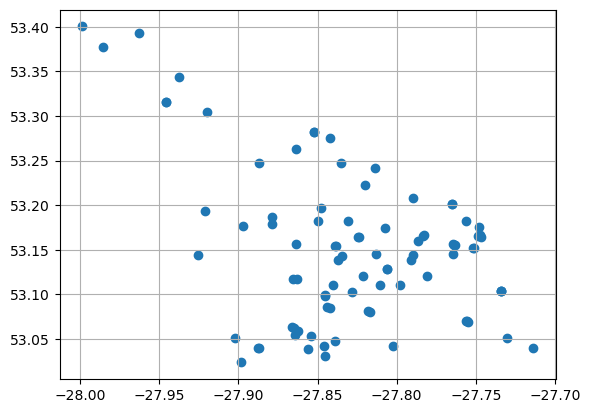

In [79]:
plt.scatter(lats, lons)

# Determine the range of the data
x_min, x_max = np.min(lats), np.max(lats)
y_min, y_max = np.min(lons), np.max(lons)

# Set the grid with intervals of 0.1
plt.grid(True)

# Generate ticks at intervals of 0.1 within the range of the data
x_ticks = np.arange(np.floor(x_min), np.ceil(x_max) + 0.1, 0.1)
y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + 0.1, 0.1)